# import packages

In [12]:
from __future__ import print_function
import pandas as pd
import numpy as np
import glob
import re
import os
import sys
import astroscrappy
from astropy.io import fits
#sys.path.remove('/Users/gks/Dropbox/mypylib')
import astropy
import matplotlib.pyplot as plt
import astropy.io.fits 


In [13]:
sys.path.append('src/')
import filepath
import utils
filepath, utils

(<module 'filepath' from 'src\\filepath.py'>,
 <module 'utils' from 'src\\utils.py'>)

In [14]:
class FitsImage(object):
    """
    A helper class when reading fits files. Depends on pyFits.
    """
    DIRLOC = ''
    def __init__(self,filename=None,data=None,header=None,imgnumber=0):
        if filename!=None:
            self.filename = filename
            self.hdulist = fits.open(self.filename)
            self.header = self.hdulist[imgnumber].header
            data = self.hdulist[imgnumber].data
            self.data = data.astype(float)
        else:
            self.filename = ""
            self.hdulist = None
            self.header = header
            self.data = data
    
    def remove_cosmics(self,
                       verbose=True,
                       fsmode='convolve',
                       save_cleaned=False,
                       savefolder=None,
                       save_suffix="_cleaned",
                       overwrite=False,
                       gain=1.,
                       psffwhm=16.,
                       psfsize=16,
                       sigclip=6.,
                       sigfrac=0.3,
                       objlim=5.,
                       psfmodel="gauss",
                       pssl=0.,
                       cleantype="medmask",
                       **cosmics_kwargs):
        """
        Remove cosmic rays with astroscrappy
        
        Main thing is to study how the results change with the different settings.
        
        Main parameters are: GAIN and psffwhm
        """
        if verbose: print("Cleaning cosmic rays")
        self.cosmics_mask, self.cosmics_cleaned_data = astroscrappy.detect_cosmics(self.data,
                                                                                   objlim=objlim,
                                                                                   sigfrac=sigfrac,
                                                                                   sigclip=sigclip,
                                                                                   psfsize=psfsize,
                                                                                   verbose=verbose,
                                                                                   gain=gain,
                                                                                   psffwhm=psffwhm,
                                                                                   fsmode=fsmode,
                                                                                   psfmodel=psfmodel,
                                                                                   pssl=pssl,
                                                                                   cleantype=cleantype,
                                                                                   **cosmics_kwargs)
        if save_cleaned:
            # Saving file
            fp = filepath.FilePath(self.filename)
            make_dir(savefolder)
            if savefolder is not None: 
                fp.directory = savefolder
            fp.add_suffix(save_suffix)
            self.cosmics_save_filename = fp._fullpath
            self.savefits(filename=self.cosmics_save_filename,
                          data=self.cosmics_cleaned_data.astype(np.int32),
                          verbose=verbose,
                          overwrite=overwrite)
    
    def savefits(self,data=None,filename="",suffix="",verbose=True,overwrite=True):
        if data is None:
            data = self.data
        if filename=="":
            fp = filepath.Filepath(self.filename)
            if suffix=="":
                suffix = "_out"
            fp.add_suffix(suffix)
            filename=fp._fullpath
        self.header["BITPIX"]=16
        self.header["BSCALE"]=1
        self.header["BZERO"]=32768
        fits.writeto(filename,
                     data=data,
                     header=self.header,
                     overwrite=overwrite,
                     output_verify="warn")
        if verbose: print("Saved to",filename)
            
def make_dir(dirname,verbose=True):
    """    Make a directory    """
    try:
        os.makedirs(dirname)
        if verbose==True: print("Created folder:",dirname)
    except OSError:
        if verbose==True: print(dirname,"already exists. Skipping")

# Find all of the files to clean

In [19]:
FOLDERNAME = os.path.abspath(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\CR_TEST''')
regex = "*177.fits"
files = glob.glob(os.path.join(FOLDERNAME,regex))

In [20]:
files

['C:\\Users\\Marissa\\Desktop\\Research\\Transits\\ARCTIC\\20210331_TIC-207x\\CR_TEST\\TIC-207-diffuser-i.0177.fits']

# Loop through all test files and clean

- This saves the files in a 0_CLEANED subdirectory in the FOLDERNAME
- appends a *_cleaned* to the filenames

k =2
j =2
0 C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\CR_TEST\TIC-207-diffuser-i.0177.fits
Cleaning cosmic rays
Starting 4 L.A.Cosmic iterations
Iteration 1:
<ipython-input-14-7b2efe561d8e>:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.cosmics_mask, self.cosmics_cleaned_data = astroscrappy.detect_cosmics(self.data,
3638 cosmic pixels this iteration
Iteration 2:
2778 cosmic pixels this iteration
Iteration 3:
1788 cosmic pixels this iteration
Iteration 4:
1174 cosmic pixels this iteration
C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\CR_TEST\0_CLEANED_SYSTEMATIC_TESTS/ already exists. Skipping
Saved to C:\Users\M

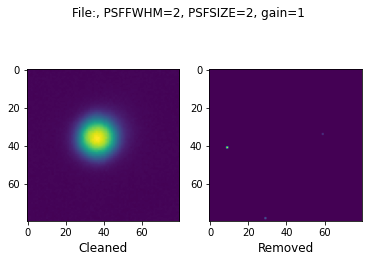

In [21]:
psffwhms = [2]
psfsizes = [2]


#rows = ['{}'.format(row) for row in ['Target', 'Reference']]
cols = ['{}'.format(col) for col in ['Cleaned', 'Removed']]

for k in psffwhms:
    for j in psfsizes:
        print("k ="+str(k))
        print("j ="+str(j))
        for i, f in enumerate(files):
            print(i,f)
            fimg = FitsImage(f)
            data_uncleaned=np.copy(fimg.data)
            fimg.remove_cosmics(save_cleaned=True,
                                    gain=1, #gain needs to be changed in 4 locations for filenames
                                    sepmed=True,
                                    overwrite=True,
                                    psffwhm=k,
                                    psfsize=j,
                                    save_suffix='_delta_cleaned_gain_1_sepmed_T_psffwhm_'+str(k)+'_psfsize_'+str(j),
                                    savefolder=os.path.join(FOLDERNAME,'0_CLEANED_SYSTEMATIC_TESTS/'))
            data_cleaned = fimg.cosmics_cleaned_data
            data_delta = data_uncleaned-data_cleaned
            fig, axx = plt.subplots(ncols=2,nrows=1)
            for ax, col in zip(axx, cols):
                ax.set_xlabel(col, rotation=0, size='large')
            axx.flatten()[0].imshow(data_cleaned[300:380,340:420])
            axx.flatten()[1].imshow(data_delta[300:380,340:420])
            #axx.flatten()[2].imshow(data_cleaned[0:2000,0:2000])
            #axx.flatten()[3].imshow(data_delta[0:2000,0:2000])
            fig.suptitle('File:'+ str(''.join(re.findall("_DiffOut_.(\d+).fits",files[i])))+', PSFFWHM='+str(k)+', PSFSIZE='+str(j) + ', gain=1') #MUST CHANGE THE REGEX OF FILENAME IF YOU WANT IT LABELLED CORRECTLY
            #fig.savefig(r'''C:\Users\Marissa\Desktop\Research\Transits\ARCTIC\20210331_TIC-207x\CR_TEST\0_CLEANED_SYSTEMATIC_TESTS\UT20210331_cleaned_gain_1_sepmed_T_psffwhm_'''+str(k)+'_psfsize_'+str(j)+'_'+str(''.join(re.findall("_DiffOut_.(\d+).fits",files[i])))+'.png',dpi=200) #MUST CHANGE THE REGEX OF FILENAME IF YOU WANT IT SAVED CORRECTLY

                      